In [1]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [5]:
import tweepy
import json
import csv
import pandas as pd
import TweetCleanser
import TweetStemToken
import settings
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
db = client.local

In [22]:
class MyListener(tweepy.StreamListener):
        
    def on_data(self, data):
        try:
            tweet = json.loads(data)
            # Filter out retweets and tweets from SouthwestAir
            if not tweet['retweeted'] and 'RT @' not in tweet['text'] and tweet['user']['screen_name'] != 'SouthwestAir':
                if db.trainTweets.find().count() <= 150:
                    id_str = tweet['id_str']
                    text = tweet['text']
                    db.trainTweets.insert_one(
                        {
                            'id_str': id_str,
                            'text': text,
                        }
                    )
                else:
                    return False
                
        except Exception as e:
            print("error: " + str(e))
        
    def on_error(self, error):
        if error == 420:
            return False
        print(error)

In [23]:
C_KEY = settings.C_KEY
C_SECRET = settings.C_SECRET
A_TOKEN_KEY = settings.A_TOKEN_KEY
A_TOKEN_SECRET = settings.A_TOKEN_SECRET

In [24]:
auth = tweepy.OAuthHandler(C_KEY, C_SECRET)
auth.set_access_token(A_TOKEN_KEY, A_TOKEN_SECRET)
api = tweepy.API(auth)

In [25]:
listener = MyListener(api=tweepy.API(wait_on_rate_limit=True))
myStream = tweepy.Stream(auth=auth, listener=listener)
myStream.filter(track=['southwest airlines', 'SouthwestAir', 'southwestairlines', 'flying southwest', 'fly southwest'])

In [26]:
tweets = db.trainTweets
print "Found", tweets.count(), "tweets:" 
for tweet in tweets.find():
    print tweet['text']

Found 151 tweets:
Southwest Airlines flight #SWA432 spotted at 16,775 feet! https://t.co/X80ugao76Q
Southwest Airlines flight #SWA227 spotted at 18,500 feet! https://t.co/FBjyFKMQEi
So cool @jasminecainrock  i bet they loved that live show @ the airport . https://t.co/TSizhtlsAz
Southwest Airlines flight #SWA227 spotted at 4,950 feet! https://t.co/FBjyFKMQEi
Southwest Airlines flight #SWA432 spotted at 29,000 feet! https://t.co/X80ugao76Q
@SouthwestAir Nobody was there when our flight got in. Like it was literally empty in Spokane international airport… https://t.co/386lkfEK2l
Southwest Airlines To Feature Live Country Music Concerts On Its Flights #muslim https://t.co/8Ak5PZCPP8 (via… https://t.co/WgePG1dQmn
@SouthwestAir You’ll for this too happen.
SMF to Austin nonstop? Let’s go. https://t.co/5Zwxi5Uhg8
Oh my god 😂 always do but had to get to ATL on super short notice for super cheap. Sorry, next time. https://t.co/fYDbjABE8i
Thank you @SouthwestAir for providing me with a voucher a

In [28]:
existingTweets = open('trainTweets.csv', 'r').read()
with open('trainTweets.csv', 'wb') as outFile:
    writer = csv.writer(outFile)
    for tweet in tweets.find():
        if tweet['id_str'] not in existingTweets:
            writer.writerow([tweet['id_str'], tweet['text'].encode('ascii', 'ignore').decode('ascii')])

In [4]:
train = pd.read_csv('trainTweets.csv', header='infer')
for index, tweet in train.iterrows():
    
    # Preprocess tweet
    text = tweet['text']
    cleanser = TweetCleanser.TweetCleanser()
    stemmer = TweetStemToken.TweetStemToken()
    processed_words = cleanser.to_ascii(text)
    processed_words = cleanser.remove_urls(processed_words)
    processed_words = cleanser.remove_special_characters(processed_words)
    processed_words = cleanser.remove_usernames(processed_words)
    processed_words = cleanser.remove_numbers(processed_words)
    processed_words = stemmer.stem(processed_words)
    processed_words = stemmer.tokenize(processed_words)
    processed_words = cleanser.remove_stopwords(processed_words)
    
    id_str = tweet['id_str']
    category = tweet['category']
    
    db.trainData.insert_one(
        {
            'id_str': id_str,
            'text': text,
            'processed_words': processed_words,
            'category': category
        }
    )

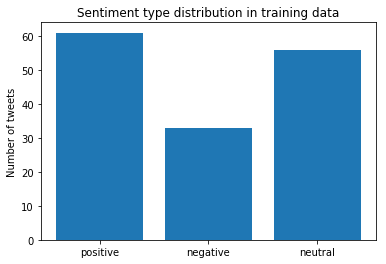

In [17]:
numPos = len(train[train['category'] == 'positive'])
numNeg = len(train[train['category'] == 'negative'])
numNeut = len(train[train['category'] == 'neutral'])

sentiments = ('positive', 'negative', 'neutral')
x = np.arange(len(sentiments))
y = [numPos, numNeg, numNeut]

plt.bar(x, y)
plt.xticks(x, sentiments)
plt.ylabel('Number of tweets')
plt.title('Sentiment type distribution in training data')